In [21]:
import requests
import zipfile
from pathlib import Path
import random
from PIL import Image
import numpy as np
import matplotlib.pylab as plt
import os
from typing import Tuple, Dict, List
from tqdm.auto import tqdm
from timeit import default_timer as timer 


from torch.utils.data import  DataLoader
from torchvision import datasets, transforms
import torch 
import torch.nn as nn
from torch.utils.data import Dataset
from torchinfo import summary

In [2]:
class ImageFolderCustom(Dataset):
    
    # 2. Initialize with a targ_dir and transform (optional) parameter
    def __init__(self, targ_dir: str, transform=None) -> None:
        
        # 3. Create class attributes
        # Get all image paths
        self.paths = list(Path(targ_dir).glob("*/*.jpg")) # note: you'd have to update this if you've got .png's or .jpeg's
        # Setup transforms
        self.transform = transform
        # Create classes and class_to_idx attributes
        # print(self.paths)
        self.classes, self.class_to_idx = self.find_classes(targ_dir)

    # 4. Make function to load images
    def load_image(self, index: int) -> Image.Image:
        "Opens an image via a path and returns it."
        image_path = self.paths[index]
        return Image.open(image_path) 
    
    # 5. Overwrite the __len__() method (optional but recommended for subclasses of torch.utils.data.Dataset)
    def __len__(self) -> int:
        "Returns the total number of samples."
        return len(self.paths)
    
    # 6. Overwrite the __getitem__() method (required for subclasses of torch.utils.data.Dataset)
    def __getitem__(self, index: int) -> Tuple[torch.Tensor, int]:
        "Returns one sample of data, data and label (X, y)."
        img = self.load_image(index)
        class_name  = self.paths[index].parent.name # expects path in data_folder/class_name/image.jpeg
        class_idx = self.class_to_idx[class_name]

        # Transform if necessary
        if self.transform:
            return self.transform(img), class_idx # return data, label (X, y)
        else:
            return img, class_idx # return data, label (X, y)
        
    def find_classes(self,directory:str)->Tuple[list[str],dict[str,int]]:
        classes=sorted(entry.name for entry in os.scandir(directory) if entry.is_dir())

        if not classes:
            raise FileNotFoundError(f"Couldn't find any classes in {directory}.")
        
        class_to_idx={cls_name: i for i, cls_name in enumerate(classes)}
        
        print(classes,class_to_idx)
        return classes,class_to_idx


In [3]:
class CustomDataTest():
    def __init__(self) -> None:

        self.train_dir = "C:\\Users\\Jakub Machura\\source\\repos\\UnderstandingDeepLearning\\data\\pizza_steak_sushi\\train"
        self.test_dir = "C:\\Users\\Jakub Machura\\source\\repos\\UnderstandingDeepLearning\\data\\pizza_steak_sushi\\test"
        """
            temp placement for of transform
        """
        self.train_transform=transforms.Compose([
            transforms.Resize(size=(64,64)),
            transforms.TrivialAugmentWide(num_magnitude_bins=31),
            transforms.ToTensor()
        ])
    
        self.test_transforms = transforms.Compose([
        transforms.Resize((64, 64)),
        transforms.ToTensor()
        ])
    
        self.train_data_custom =ImageFolderCustom(self.train_dir,transform=self.train_transform)
        self.test_data_custom=ImageFolderCustom(self.test_dir,transform=self.test_transforms)
    
        """temp place for testing data"""    
        # Check for equality amongst our custom Dataset and ImageFolder Dataset
        # print((len(self.train_data_custom) == len(data.train_data)) & (len(self.test_data_custom) == len(data.test_data)))
        # print(self.train_data_custom.classes == data.train_data.classes)
        # print(self.train_data_custom.class_to_idx == data.train_data.class_to_idx)

        self.IntoDataLoaders()

    def IntoDataLoaders(self):
        BATCH_SIZE=32
        # NUM_WORKERS = os.cpu_count()
        NUM_WORKERS = 1

        # print(f"number of workers avalible {NUM_WORKERS}")
        self.train_dataloader= DataLoader(dataset=self.train_data_custom, # use custom created train Dataset
                                     batch_size=BATCH_SIZE, # how many samples per batch?
                                    #  num_workers=NUM_WORKERS, # how many subprocesses to use for data loading? (higher = more)
                                     shuffle=True) # shuffle the data?

        self.test_dataloader = DataLoader(dataset=self.test_data_custom, # use custom created test Dataset
                                    batch_size=BATCH_SIZE, 
                                    # num_workers=NUM_WORKERS, 
                                    shuffle=False) # don't usually need to shuffle testing data

        img,label=next(iter(self.test_dataloader))
        # print(f"shape of custome dataloader img {img.shape}")

TinnyVGG with no regularization method applied

In [4]:
def train_step(model,loss_fn,optimizer,data):
        model.train()

        train_loss,train_acc=0, 0

        for batch, (X,y) in enumerate(data.train_dataloader):
            y_logits=model(X)

            loss=loss_fn(y_logits,y)
            train_loss+=loss.item()

            optimizer.zero_grad()

            loss.backward()

            optimizer.step()

            y_pred_class = y_logits.argmax(dim=1)
            train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

        train_loss=train_loss/len(data.train_dataloader)
        train_acc=train_loss/len(data.train_dataloader)
        return train_loss,train_acc
    
def test_step(model,loss_fn,data:CustomDataTest):
    
    model.eval()
    test_loss,test_acc=0,0
    with torch.inference_mode():
        for batch, (X,y) in enumerate(data.test_dataloader):

            y_logits=model(X)

            loss=loss_fn(y_logits,y)
            test_loss+=loss.item()

            test_pred_labels = y_logits.argmax(dim=1)
            test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))

    test_loss=test_loss/len(data.test_dataloader)
    test_acc=test_acc/len(data.test_dataloader)
    return test_loss, test_acc

def Totrain(model,data:CustomDataTest,epochs:int,optimizer,loss_fn:torch.nn.Module):
        
    results = {"train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": []
    }
    

    for epoch in tqdm(range(epochs)):
        train_loss,train_acc=train_step(model,loss_fn,optimizer,data)
        test_loss,test_acc=test_step(model,loss_fn,data)
                # 4. Print out what's happening
        
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 5. Update results dictionary
        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)
    
    return results

In [5]:
class TinnyVGG(nn.Module):
    def __init__(self,in_shape:int,out_shape:int,hidden_units:int) -> None:
        super().__init__()

        self.conv_block1=nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,out_features=out_shape)
        )
        print(self.state_dict)
    def forward(self,x):
        return(self.classifier(self.conv_block_2(self.conv_block1(x))))
    
    def ShapeCheck(self,data:CustomDataTest):
        img_batch,label_batch=next(iter(data.test_dataloader))

        img_single,label_single=img_batch[0].unsqueeze(dim=0), label_batch[0]
        
        # print(f"single img shape {img_single.shape}")

        self.eval()
        with torch.inference_mode():
            y=self(img_single)

        # print(f"shape of output raw y\n{y.shape}")
        # print(f"output of pred label \n{torch.argmax(torch.softmax(y,dim=1),dim=1)}")
        # print(f"actual label \n{label_single}")
    
    # def train_step(self,loss_fn,optimizer,data):
    #     self.train()

    #     train_loss,train_acc=0, 0

    #     for batch, (X,y) in enumerate(data.train_dataloader):
    #         y_logits=self(X)

    #         loss=loss_fn(y_logits,y)
    #         train_loss+=loss.item()

    #         optimizer.zero_grad()

    #         loss.backward()

    #         optimizer.step()

    #         y_pred_class = y_logits.argmax(dim=1)
    #         train_acc += (y_pred_class == y).sum().item()/len(y_pred_class)

    #     train_loss=train_loss/len(data.train_dataloader)
    #     train_acc=train_loss/len(data.train_dataloader)
    #     return train_loss,train_acc
    
    # def test_step(self,loss_fn,data:CustomDataTest):
        
    #     self.eval()

    #     test_loss,test_acc=0,0

    #     with torch.inference_mode():
    #         for batch, (X,y) in enumerate(data.test_dataloader):
    #             y_logits=self(X)

    #             loss=loss_fn(y_logits,y)
    #             test_loss+=loss.item()

    #             test_pred_labels = y_logits.argmax(dim=1)
    #             test_acc += ((test_pred_labels == y).sum().item()/len(test_pred_labels))


    #     test_loss=test_loss/len(data.test_dataloader)
    #     test_acc=test_acc/len(data.test_dataloader)
    #     return test_loss, test_acc

    # def Totrain(self,data:CustomDataTest,epochs:int,optimizer,loss_fn:torch.nn.Module):
        
    #     self.results = {"train_loss": [],
    #     "train_acc": [],
    #     "test_loss": [],
    #     "test_acc": []
    # }
    

    #     for epoch in tqdm(range(epochs)):
    #         train_loss,train_acc=self.train_step(loss_fn,optimizer,data)

    #         test_loss,test_acc=self.test_step(loss_fn,data)

    #                 # 4. Print out what's happening
    #         print(
    #             f"Epoch: {epoch+1} | "
    #             f"train_loss: {train_loss:.4f} | "
    #             f"train_acc: {train_acc:.4f} | "
    #             f"test_loss: {test_loss:.4f} | "
    #             f"test_acc: {test_acc:.4f}"
    #         )
    
    #         # 5. Update results dictionary
    #         self.results["train_loss"].append(train_loss)
    #         self.results["train_acc"].append(train_acc)
    #         self.results["test_loss"].append(test_loss)
    #         self.results["test_acc"].append(test_acc)
        
    #     return self.results

In [6]:
def plot_loss_curves(results: Dict[str, List[float]]):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    
    # Get the loss values of the results dictionary (training and test)
    loss = results['train_loss']
    test_loss = results['test_loss']

    # Get the accuracy values of the results dictionary (training and test)
    accuracy = results['train_acc']
    test_accuracy = results['test_acc']

    # Figure out how many epochs there were
    epochs = range(len(results['train_loss']))

    # Setup a plot 
    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label='train_loss')
    plt.plot(epochs, test_loss, label='test_loss')
    plt.title('Loss')
    plt.xlabel('Epochs')
    plt.legend()
    # plt.show()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label='train_accuracy')
    plt.plot(epochs, test_accuracy, label='test_accuracy')
    plt.title('Accuracy')
    plt.xlabel('Epochs')
    plt.legend()
    plt.show()

['pizza', 'steak', 'sushi'] {'pizza': 0, 'steak': 1, 'sushi': 2}
['pizza', 'steak', 'sushi'] {'pizza': 0, 'steak': 1, 'sushi': 2}
<bound method Module.state_dict of TinnyVGG(
  (conv_block1): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block_2): Sequential(
    (0): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=1280, out_features=3, bias=True)
  )
)>


  7%|▋         | 1/15 [00:01<00:15,  1.07s/it]

Epoch: 1 | train_loss: 1.1021 | train_acc: 0.1378 | test_loss: 1.0940 | test_acc: 0.5417


 13%|█▎        | 2/15 [00:01<00:11,  1.15it/s]

Epoch: 2 | train_loss: 1.1041 | train_acc: 0.1380 | test_loss: 1.0842 | test_acc: 0.5417


 20%|██        | 3/15 [00:02<00:09,  1.25it/s]

Epoch: 3 | train_loss: 1.1047 | train_acc: 0.1381 | test_loss: 1.0910 | test_acc: 0.5312


 27%|██▋       | 4/15 [00:03<00:08,  1.27it/s]

Epoch: 4 | train_loss: 1.1008 | train_acc: 0.1376 | test_loss: 1.0992 | test_acc: 0.2604


 33%|███▎      | 5/15 [00:04<00:08,  1.24it/s]

Epoch: 5 | train_loss: 1.0970 | train_acc: 0.1371 | test_loss: 1.1037 | test_acc: 0.2604


 40%|████      | 6/15 [00:05<00:07,  1.18it/s]

Epoch: 6 | train_loss: 1.1016 | train_acc: 0.1377 | test_loss: 1.1058 | test_acc: 0.2604


 47%|████▋     | 7/15 [00:05<00:06,  1.18it/s]

Epoch: 7 | train_loss: 1.0982 | train_acc: 0.1373 | test_loss: 1.0988 | test_acc: 0.2604


 53%|█████▎    | 8/15 [00:06<00:05,  1.21it/s]

Epoch: 8 | train_loss: 1.0947 | train_acc: 0.1368 | test_loss: 1.0976 | test_acc: 0.2812


 60%|██████    | 9/15 [00:07<00:04,  1.25it/s]

Epoch: 9 | train_loss: 1.0923 | train_acc: 0.1365 | test_loss: 1.0859 | test_acc: 0.2708


 67%|██████▋   | 10/15 [00:08<00:03,  1.30it/s]

Epoch: 10 | train_loss: 1.0944 | train_acc: 0.1368 | test_loss: 1.0637 | test_acc: 0.5540


 73%|███████▎  | 11/15 [00:08<00:03,  1.32it/s]

Epoch: 11 | train_loss: 1.0908 | train_acc: 0.1364 | test_loss: 1.0881 | test_acc: 0.3116


 80%|████████  | 12/15 [00:09<00:02,  1.33it/s]

Epoch: 12 | train_loss: 1.0900 | train_acc: 0.1362 | test_loss: 1.0982 | test_acc: 0.3229


 87%|████████▋ | 13/15 [00:10<00:01,  1.36it/s]

Epoch: 13 | train_loss: 1.0971 | train_acc: 0.1371 | test_loss: 1.0822 | test_acc: 0.3021


 93%|█████████▎| 14/15 [00:10<00:00,  1.38it/s]

Epoch: 14 | train_loss: 1.0619 | train_acc: 0.1327 | test_loss: 1.0473 | test_acc: 0.3021


100%|██████████| 15/15 [00:11<00:00,  1.28it/s]

Epoch: 15 | train_loss: 1.1253 | train_acc: 0.1407 | test_loss: 1.0689 | test_acc: 0.2812
Total training time: 11.697 seconds


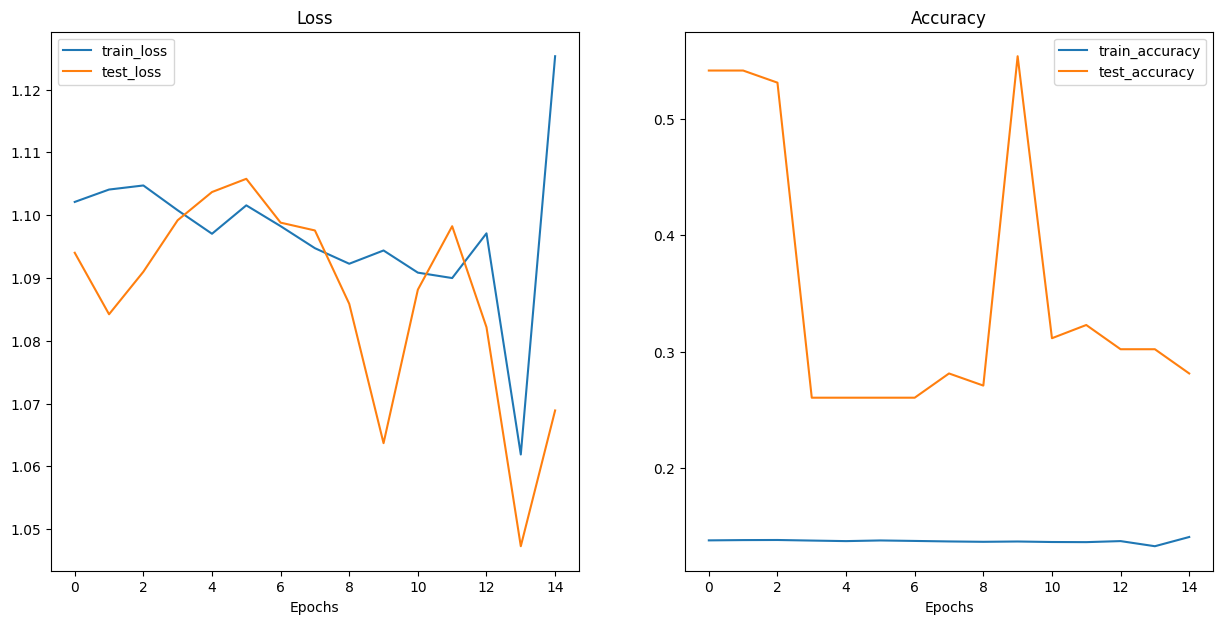

In [7]:

data1=CustomDataTest()
model0=TinnyVGG(3,len(data1.train_data_custom.classes),5)

model0_optimizer=torch.optim.Adam(params=model0.parameters(),lr=0.001)
model0_loss_fn=nn.CrossEntropyLoss()

start_time=timer()
model0_results=Totrain(model0,data=data1,epochs=15,optimizer=model0_optimizer,loss_fn=model0_loss_fn)

end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_loss_curves(model0_results)

Model with 

In [8]:
class TinnyVGGNorm2D(nn.Module):
    def __init__(self,in_shape:int,out_shape:int,hidden_units:int) -> None:
        super().__init__()

        self.conv_block1=nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.InstanceNorm2d(num_features=hidden_units,eps=1e-5,momentum=0.1,affine=True),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.InstanceNorm2d(num_features=hidden_units,eps=1e-5,momentum=0.1,affine=True),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        )
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*32*32,out_features=out_shape)
        )
        print(self.state_dict)
    def forward(self,x):
        return(self.classifier(self.conv_block1(x)))
    


<bound method Module.state_dict of TinnyVGGNorm2D(
  (conv_block1): Sequential(
    (0): Conv2d(3, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): InstanceNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (2): ReLU()
    (3): Conv2d(5, 5, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): InstanceNorm2d(5, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
    (5): ReLU()
    (6): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=5120, out_features=3, bias=True)
  )
)>


  2%|▏         | 1/50 [00:00<00:39,  1.25it/s]

Epoch: 1 | train_loss: 1.2857 | train_acc: 0.1607 | test_loss: 1.2473 | test_acc: 0.3627


  4%|▍         | 2/50 [00:01<00:35,  1.34it/s]

Epoch: 2 | train_loss: 0.9404 | train_acc: 0.1175 | test_loss: 1.3549 | test_acc: 0.4432


  6%|▌         | 3/50 [00:02<00:34,  1.37it/s]

Epoch: 3 | train_loss: 1.2209 | train_acc: 0.1526 | test_loss: 1.4003 | test_acc: 0.3835


  8%|▊         | 4/50 [00:02<00:33,  1.36it/s]

Epoch: 4 | train_loss: 0.9908 | train_acc: 0.1238 | test_loss: 1.3660 | test_acc: 0.4848


 10%|█         | 5/50 [00:03<00:33,  1.36it/s]

Epoch: 5 | train_loss: 0.7805 | train_acc: 0.0976 | test_loss: 1.7963 | test_acc: 0.3125


 12%|█▏        | 6/50 [00:04<00:32,  1.34it/s]

Epoch: 6 | train_loss: 0.8958 | train_acc: 0.1120 | test_loss: 1.4794 | test_acc: 0.3939


 14%|█▍        | 7/50 [00:05<00:31,  1.36it/s]

Epoch: 7 | train_loss: 0.8336 | train_acc: 0.1042 | test_loss: 1.2166 | test_acc: 0.3835


 16%|█▌        | 8/50 [00:05<00:30,  1.37it/s]

Epoch: 8 | train_loss: 0.7468 | train_acc: 0.0934 | test_loss: 1.7178 | test_acc: 0.2917


 18%|█▊        | 9/50 [00:06<00:29,  1.37it/s]

Epoch: 9 | train_loss: 0.8728 | train_acc: 0.1091 | test_loss: 1.1300 | test_acc: 0.4441


 20%|██        | 10/50 [00:07<00:29,  1.35it/s]

Epoch: 10 | train_loss: 0.7178 | train_acc: 0.0897 | test_loss: 1.1512 | test_acc: 0.4441


 22%|██▏       | 11/50 [00:08<00:28,  1.37it/s]

Epoch: 11 | train_loss: 0.9283 | train_acc: 0.1160 | test_loss: 1.1343 | test_acc: 0.4422


 24%|██▍       | 12/50 [00:08<00:27,  1.37it/s]

Epoch: 12 | train_loss: 0.8924 | train_acc: 0.1116 | test_loss: 2.0390 | test_acc: 0.3324


 26%|██▌       | 13/50 [00:09<00:26,  1.38it/s]

Epoch: 13 | train_loss: 0.8968 | train_acc: 0.1121 | test_loss: 1.3425 | test_acc: 0.5634


 28%|██▊       | 14/50 [00:10<00:26,  1.37it/s]

Epoch: 14 | train_loss: 0.9384 | train_acc: 0.1173 | test_loss: 2.6733 | test_acc: 0.3229


 30%|███       | 15/50 [00:10<00:25,  1.38it/s]

Epoch: 15 | train_loss: 1.2809 | train_acc: 0.1601 | test_loss: 1.1372 | test_acc: 0.6061


 32%|███▏      | 16/50 [00:11<00:25,  1.35it/s]

Epoch: 16 | train_loss: 0.6073 | train_acc: 0.0759 | test_loss: 1.3402 | test_acc: 0.3939


 34%|███▍      | 17/50 [00:12<00:24,  1.34it/s]

Epoch: 17 | train_loss: 0.6551 | train_acc: 0.0819 | test_loss: 1.2297 | test_acc: 0.4659


 36%|███▌      | 18/50 [00:13<00:23,  1.35it/s]

Epoch: 18 | train_loss: 0.5908 | train_acc: 0.0739 | test_loss: 1.1074 | test_acc: 0.4441


 38%|███▊      | 19/50 [00:14<00:22,  1.35it/s]

Epoch: 19 | train_loss: 0.6828 | train_acc: 0.0853 | test_loss: 1.5477 | test_acc: 0.3722


 40%|████      | 20/50 [00:14<00:21,  1.38it/s]

Epoch: 20 | train_loss: 0.6748 | train_acc: 0.0843 | test_loss: 1.2046 | test_acc: 0.3920


 42%|████▏     | 21/50 [00:15<00:21,  1.36it/s]

Epoch: 21 | train_loss: 0.5584 | train_acc: 0.0698 | test_loss: 1.3168 | test_acc: 0.3523


 44%|████▍     | 22/50 [00:16<00:20,  1.36it/s]

Epoch: 22 | train_loss: 0.5261 | train_acc: 0.0658 | test_loss: 1.0521 | test_acc: 0.4650


 46%|████▌     | 23/50 [00:16<00:19,  1.37it/s]

Epoch: 23 | train_loss: 0.8794 | train_acc: 0.1099 | test_loss: 1.6852 | test_acc: 0.3125


 48%|████▊     | 24/50 [00:17<00:18,  1.37it/s]

Epoch: 24 | train_loss: 0.7910 | train_acc: 0.0989 | test_loss: 1.3172 | test_acc: 0.3722


 50%|█████     | 25/50 [00:18<00:18,  1.37it/s]

Epoch: 25 | train_loss: 0.7650 | train_acc: 0.0956 | test_loss: 1.1708 | test_acc: 0.4650


 52%|█████▏    | 26/50 [00:19<00:17,  1.37it/s]

Epoch: 26 | train_loss: 0.7561 | train_acc: 0.0945 | test_loss: 1.5336 | test_acc: 0.3731


 54%|█████▍    | 27/50 [00:19<00:16,  1.35it/s]

Epoch: 27 | train_loss: 0.7604 | train_acc: 0.0950 | test_loss: 1.2312 | test_acc: 0.4536


 56%|█████▌    | 28/50 [00:20<00:16,  1.37it/s]

Epoch: 28 | train_loss: 0.6768 | train_acc: 0.0846 | test_loss: 1.5851 | test_acc: 0.3011


 58%|█████▊    | 29/50 [00:21<00:15,  1.37it/s]

Epoch: 29 | train_loss: 0.5934 | train_acc: 0.0742 | test_loss: 1.0968 | test_acc: 0.5161


 60%|██████    | 30/50 [00:22<00:14,  1.36it/s]

Epoch: 30 | train_loss: 0.5522 | train_acc: 0.0690 | test_loss: 1.3389 | test_acc: 0.3523


 62%|██████▏   | 31/50 [00:22<00:14,  1.36it/s]

Epoch: 31 | train_loss: 0.9504 | train_acc: 0.1188 | test_loss: 0.9898 | test_acc: 0.6581


 64%|██████▍   | 32/50 [00:23<00:13,  1.37it/s]

Epoch: 32 | train_loss: 1.1431 | train_acc: 0.1429 | test_loss: 1.7596 | test_acc: 0.2812


 66%|██████▌   | 33/50 [00:24<00:12,  1.38it/s]

Epoch: 33 | train_loss: 0.8973 | train_acc: 0.1122 | test_loss: 1.1465 | test_acc: 0.5862


 68%|██████▊   | 34/50 [00:24<00:11,  1.40it/s]

Epoch: 34 | train_loss: 0.8784 | train_acc: 0.1098 | test_loss: 2.1090 | test_acc: 0.3125


 70%|███████   | 35/50 [00:25<00:10,  1.41it/s]

Epoch: 35 | train_loss: 0.8275 | train_acc: 0.1034 | test_loss: 1.2726 | test_acc: 0.4839


 72%|███████▏  | 36/50 [00:26<00:09,  1.41it/s]

Epoch: 36 | train_loss: 0.8788 | train_acc: 0.1098 | test_loss: 1.7242 | test_acc: 0.3333


 74%|███████▍  | 37/50 [00:27<00:09,  1.38it/s]

Epoch: 37 | train_loss: 0.7025 | train_acc: 0.0878 | test_loss: 1.7092 | test_acc: 0.3826


 76%|███████▌  | 38/50 [00:27<00:08,  1.35it/s]

Epoch: 38 | train_loss: 0.6988 | train_acc: 0.0873 | test_loss: 1.6066 | test_acc: 0.3333


 78%|███████▊  | 39/50 [00:28<00:08,  1.33it/s]

Epoch: 39 | train_loss: 0.7895 | train_acc: 0.0987 | test_loss: 1.0514 | test_acc: 0.6174


 80%|████████  | 40/50 [00:29<00:07,  1.32it/s]

Epoch: 40 | train_loss: 0.8298 | train_acc: 0.1037 | test_loss: 1.3486 | test_acc: 0.3627


 82%|████████▏ | 41/50 [00:30<00:06,  1.32it/s]

Epoch: 41 | train_loss: 0.6043 | train_acc: 0.0755 | test_loss: 1.0469 | test_acc: 0.5256


 84%|████████▍ | 42/50 [00:30<00:06,  1.31it/s]

Epoch: 42 | train_loss: 0.5687 | train_acc: 0.0711 | test_loss: 1.2296 | test_acc: 0.4650


 86%|████████▌ | 43/50 [00:31<00:05,  1.32it/s]

Epoch: 43 | train_loss: 0.5993 | train_acc: 0.0749 | test_loss: 1.0896 | test_acc: 0.5265


 88%|████████▊ | 44/50 [00:32<00:04,  1.32it/s]

Epoch: 44 | train_loss: 0.5081 | train_acc: 0.0635 | test_loss: 1.0803 | test_acc: 0.5369


 90%|█████████ | 45/50 [00:33<00:03,  1.31it/s]

Epoch: 45 | train_loss: 0.5614 | train_acc: 0.0702 | test_loss: 1.1817 | test_acc: 0.4754


 92%|█████████▏| 46/50 [00:34<00:03,  1.28it/s]

Epoch: 46 | train_loss: 0.3737 | train_acc: 0.0467 | test_loss: 1.2699 | test_acc: 0.4555


 94%|█████████▍| 47/50 [00:34<00:02,  1.29it/s]

Epoch: 47 | train_loss: 0.3996 | train_acc: 0.0500 | test_loss: 1.3488 | test_acc: 0.4650


 96%|█████████▌| 48/50 [00:35<00:01,  1.31it/s]

Epoch: 48 | train_loss: 0.3410 | train_acc: 0.0426 | test_loss: 1.1100 | test_acc: 0.5578


 98%|█████████▊| 49/50 [00:36<00:00,  1.32it/s]

Epoch: 49 | train_loss: 0.4049 | train_acc: 0.0506 | test_loss: 1.1629 | test_acc: 0.4754


100%|██████████| 50/50 [00:37<00:00,  1.35it/s]

Epoch: 50 | train_loss: 0.3827 | train_acc: 0.0478 | test_loss: 1.3439 | test_acc: 0.4347
Total training time: 37.034 seconds


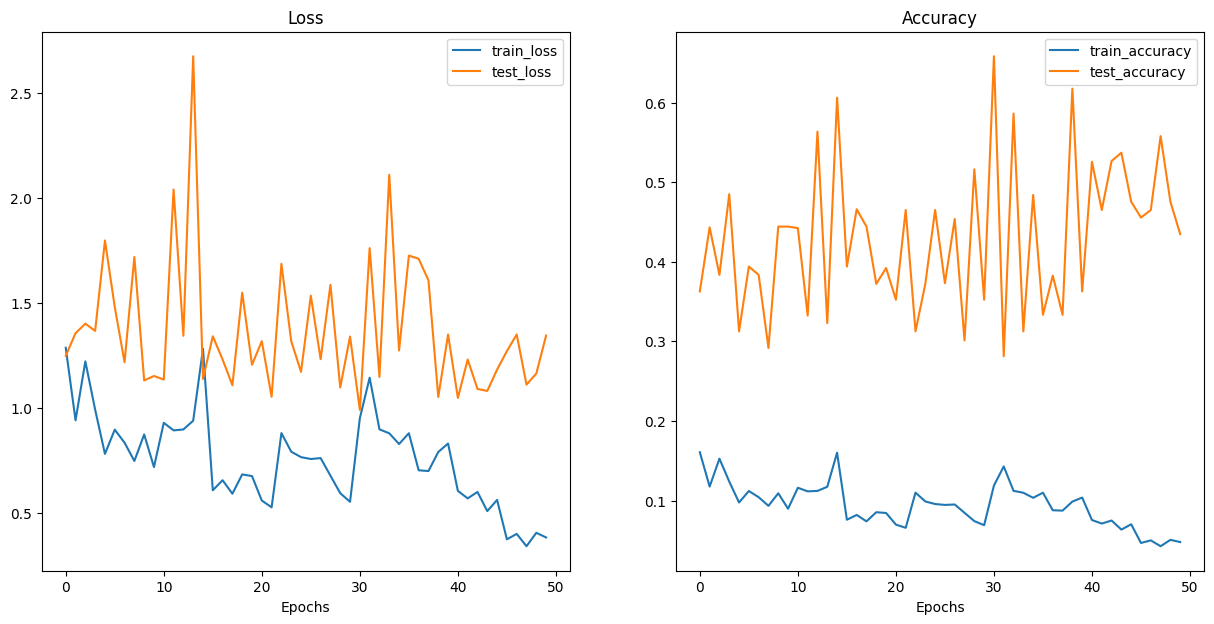

In [9]:
model1=TinnyVGGNorm2D(3,len(data1.train_data_custom.classes),5)

model1_optimizer=torch.optim.Adam(params=model1.parameters(),lr=0.001)
model1_loss_fn=nn.CrossEntropyLoss()

start_time=timer()
model1_results=Totrain(model1,data=data1,epochs=50,optimizer=model1_optimizer,loss_fn=model1_loss_fn)

end_time=timer()
print(f"Total training time: {end_time-start_time:.3f} seconds")
plot_loss_curves(model1_results)

Testing usage of BlockDrop on TinnyVGG with InstanceNorm2d regularization 
BlockDrop class 

In [10]:

class BlockDrop(nn.Module):
    def __init__(self, block, p=0.5):
        super(BlockDrop, self).__init__()
        self.block = block
        self.p = p

    def forward(self, x):
        if self.training:
            return self.block(x) if torch.rand(1) > self.p else x
        return self.block(x)

class TinnyVGGBlockDrop(nn.Module):
    def __init__(self,in_shape:int,out_shape:int,hidden_units:int) -> None:
        super().__init__()

        self.conv_block1=BlockDrop(nn.Sequential(
            nn.Conv2d(in_channels=in_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(
                in_channels=hidden_units,
                out_channels=hidden_units,
                kernel_size=3,
                stride=1,
                padding=1
            ),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,stride=2)
        ))
        self.conv_block_2 = BlockDrop(nn.Sequential(
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.Conv2d(hidden_units, hidden_units, kernel_size=3, padding=1),
            nn.InstanceNorm2d(hidden_units),
            nn.ReLU(),
            nn.MaxPool2d(2)
        ))
        self.classifier=nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*16*16,out_features=out_shape)
        )
        print(self.state_dict)
    def forward(self,x):
        return(self.classifier(self.conv_block_2(self.conv_block1(x))))
    
    
   


tensor([0])

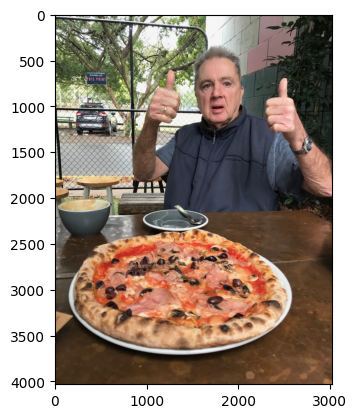

In [30]:
import torchvision
custom_img_path="C:\\Users\\Jakub Machura\\source\\repos\\UnderstandingDeepLearning\\data\\04-pizza-dad.jpeg"
custom_img_unit8=torchvision.io.read_image(str(custom_img_path))

# torch.Size([3, 4032, 3024])
custom_img_unit8.shape
# torch.uint8
custom_img_unit8.dtype

custom_image=custom_img_unit8=torchvision.io.read_image(str(custom_img_path)).type(torch.float32)
# Divide the image pixel values by 255 to get them between [0, 1]
custom_image = custom_image / 255. 
# torch.float32
custom_image.dtype


plt.imshow(custom_image.permute(1,2,0)) # need to permute image dimensions from CHW -> HWC otherwise matplotlib will error

custom_img_transform=transforms.Compose([
    transforms.Resize((64,64)),
])

custom_image_transformed=custom_img_transform(custom_image) 

custom_image_transformed.shape

model1.eval()
with torch.inference_mode():
    custom_image_transformed_with_batch_size=custom_image_transformed.unsqueeze(dim=0)

    custom_img_pred=model1(custom_image_transformed_with_batch_size)
data1.classname() custom_img_pred.argmax(dim=1)